# Code for Figure 2 & S2

# Load simulation data

In [1]:
%%time
%load_ext autoreload
from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "./data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))
    
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 8.35 s, sys: 2.66 s, total: 11 s
Wall time: 8.32 s


## Wildtype

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
R^2:  0.3624675731274821
slope:  1.1129143869335623
192.15248926678188
Min. transcript elongation latency:  172.15134213190092
Max. transcript elongation latency:  216.74928089682058
Standard deviation of elongation latency distrib:   5.602856957060729


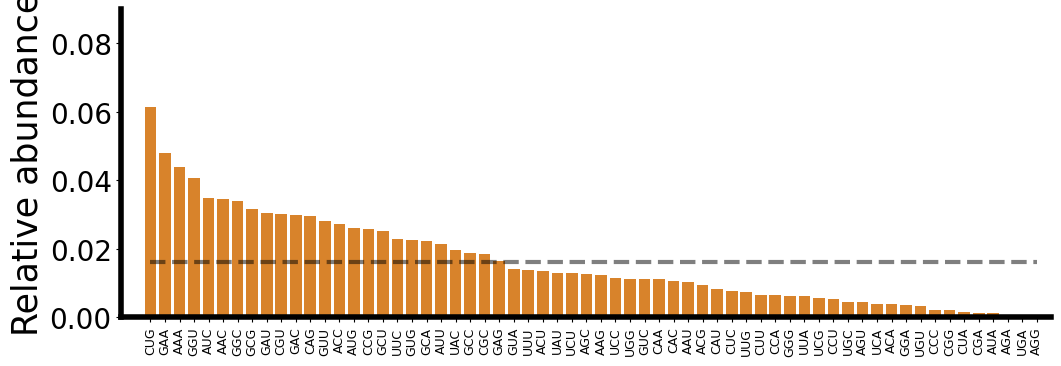

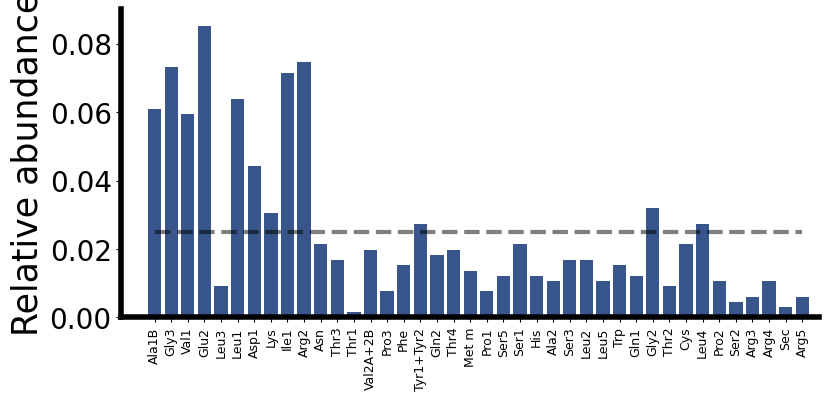

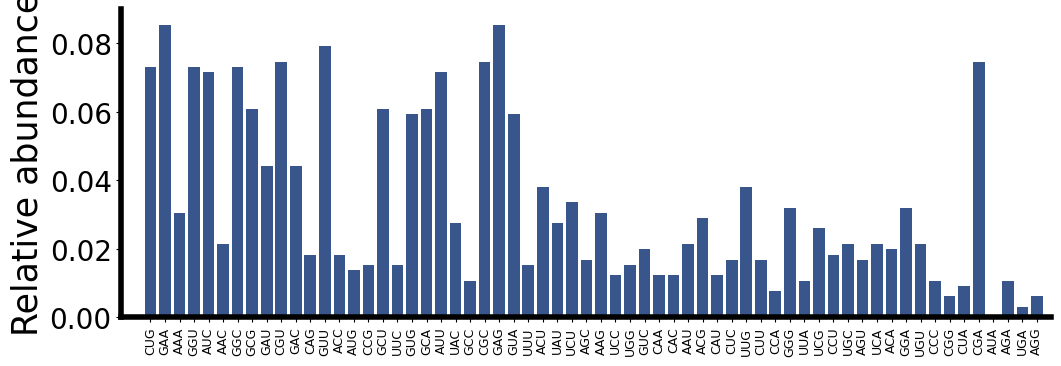

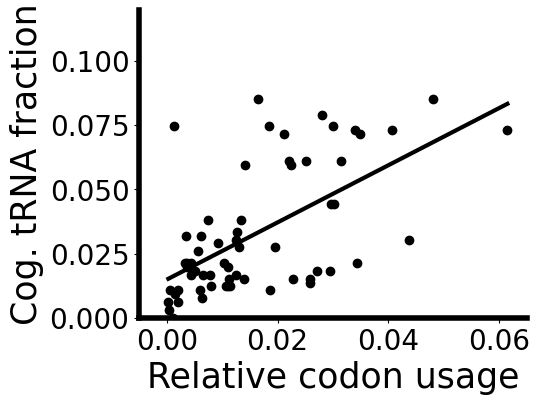

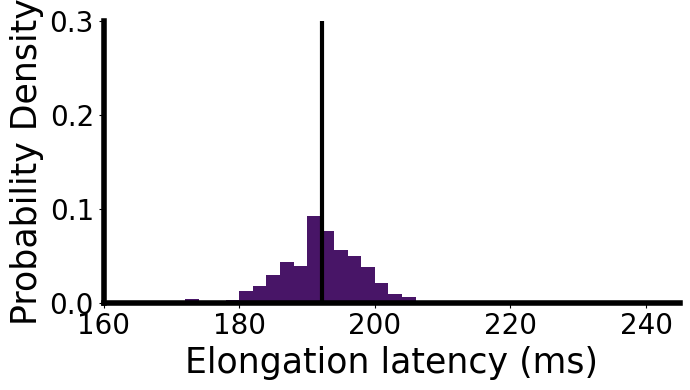

In [2]:
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Plot codon frequency sorted by decreasing frequency
fig,ax = plt.subplots(figsize=(12,4))
ax.bar(np.arange(62),pCodon_sorted,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylabel('Relative abundance',fontsize=25)


#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
ax2.set_xlim(-2,40)
ax2.set_ylabel('Relative abundance',fontsize=25)
ptRNA_sorted_WT = ptRNA_sorted
tRNA_sorted_WT = tRNA_sorted



## Sort and plot cognate tRNA distribution per codon 
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('Relative abundance',fontsize=25)

for ax in [ax,ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)
   # ax.set_yticks(np.arange(0,0.36,0.05))



####Plot tRNA frequency vs. codon frequency######
fig,ax3 = plt.subplots(figsize=(5,4))
ax3.scatter(pCodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

y_model,SS_err,_,_,_ = np.polyfit(pCodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pCodon_sorted)
x_sweep_i = np.linspace(min(pCodon_sorted),max(pCodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax3.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pCodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pCodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)
ax3.set_xlim(-0.005,0.065)
ax3.set_ylim(0,0.12)
ax3.set_xlabel('Relative codon usage',fontsize=25)
ax3.set_ylabel('Cog. tRNA fraction',fontsize=25)


#Plot the elongation latency of each gene
fig,ax4 = plt.subplots(figsize=(7,4))
transcriptome_elongt_WT = transcriptome_elongt

hist=ax4.hist(transcriptome_elongt,color='#481567FF',bins=30,range=(170,230),density=True)
print(np.average(transcriptome_elongt))
ax4.plot([np.average(transcriptome_elongt_WT)]*100,np.linspace(0,0.4,100),linewidth=3,color='black')

ax4.set_ylim(0,0.3)
ax4.set_xlim(160,245)

ax4.set_xlabel('Elongation latency (ms)',size=25)
ax4.set_ylabel('Probability Density',size=25)

for ax in [ax3,ax4]:
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    
print("Min. transcript elongation latency: ", min(transcriptome_elongt))
print("Max. transcript elongation latency: ", max(transcriptome_elongt))
print("Standard deviation of elongation latency distrib:  ", np.std(transcriptome_elongt))


plt.tight_layout()

## Uniform

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
ptRNA  [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
R^2:  0.016511070132997796
slope:  0.10795079542582085
214.3004854955901
1.1152626037441453
(2.0322378716744915, 0.9715179968701095)
(array([0.00000000e+00, 0.00000000e+00, 0.00000000e

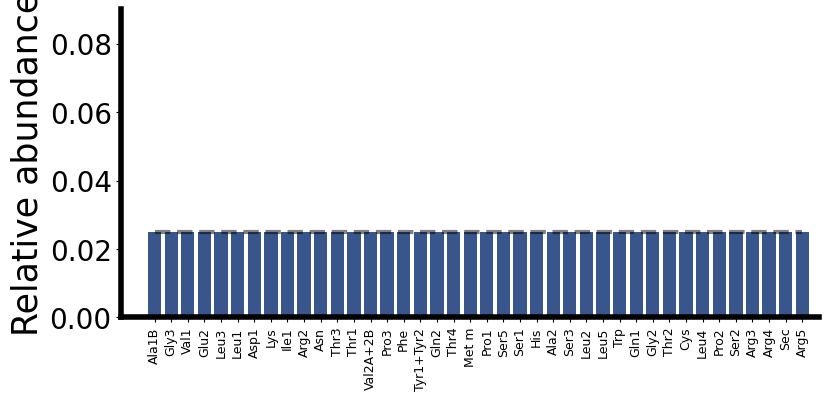

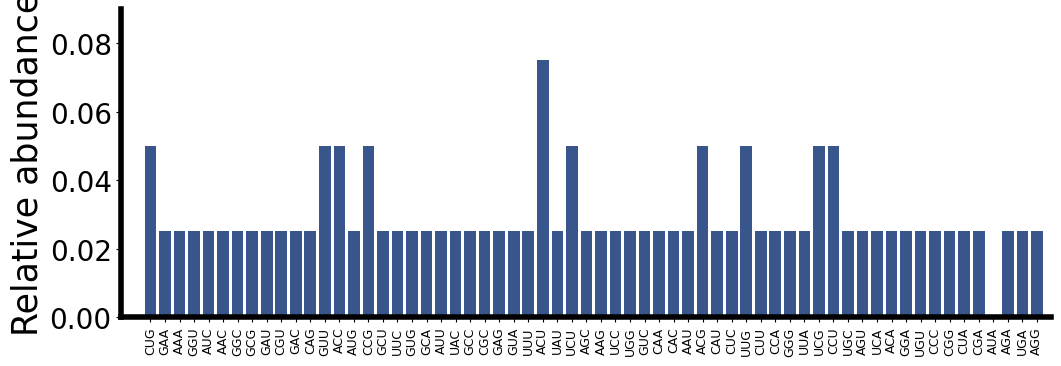

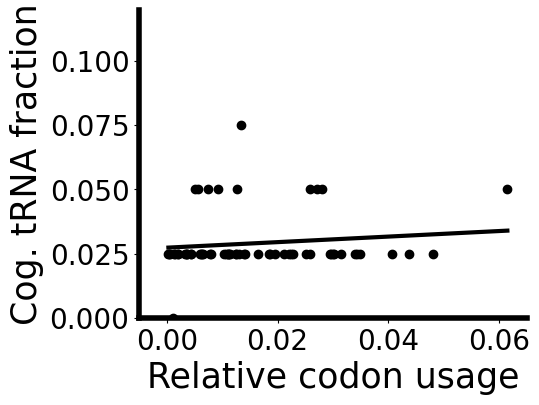

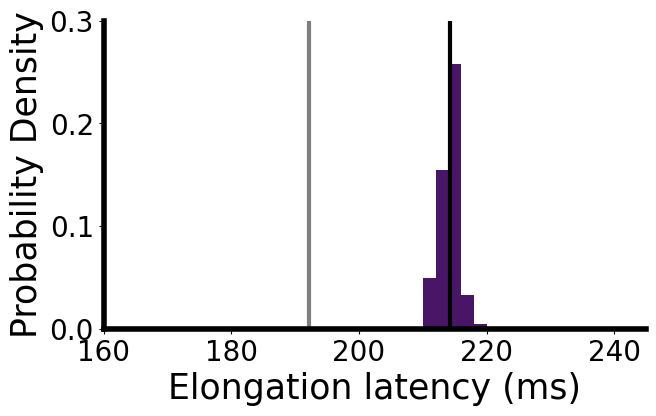

In [3]:
#Uniform
ptRNA_uniform = np.ones(len(gr25_ptRNA))/sum(np.ones(len(gr25_ptRNA)))
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(ptRNA_uniform, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(ptRNA_uniform,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = ptRNA_uniform[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
ax2.set_xlim(-2,40)
ax2.set_ylabel('Relative abundance',fontsize=25)
ptRNA_sorted_uniform = ptRNA_sorted
print("ptRNA ", ptRNA_sorted)


## Sort and plot cognate tRNA distribution per codon 
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('Relative abundance',fontsize=25)

for ax in [ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)
   # ax.set_yticks(np.arange(0,0.36,0.05))

####Plot tRNA frequency vs. codon frequency######
fig,ax3 = plt.subplots(figsize=(5,4))
ax3.scatter(pCodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

y_model,SS_err,_,_,_ = np.polyfit(pCodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pCodon_sorted)
x_sweep_i = np.linspace(min(pCodon_sorted),max(pCodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax3.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pCodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pCodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)
ax3.set_xlim(-0.005,0.065)
ax3.set_ylim(0,0.12)
ax3.set_xlabel('Relative codon usage',fontsize=25)
ax3.set_ylabel('Cog. tRNA fraction',fontsize=25)

#Plot the elongation latency of each gene
fig1,ax4 = plt.subplots(figsize=(7,4))

hist=ax4.hist(transcriptome_elongt,color='#481567FF',bins=30,range=(180,240),density=True)
ax4.plot([np.average(transcriptome_elongt)]*100,np.linspace(0,0.4,100),linewidth=3,color='black')
ax4.plot([np.average(transcriptome_elongt_WT)]*100,np.linspace(0,0.4,100),linewidth=3,color='black',alpha=0.5)

print(np.average(transcriptome_elongt))
ax4.set_ylim(0,0.3)
ax4.set_xlim(160,245)
ax4.set_xlabel('Elongation latency (ms)',size=25)
ax4.set_ylabel('Probability Density',size=25)

for ax in [ax3,ax4]:
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    
fig.savefig('./Figures/2a-middle.svg', dpi=300,bbox_inches='tight')
fig1.savefig('./Figures/2a-right.svg', dpi=300,bbox_inches='tight')


print(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT))
print(computeEffectiveGrowthRateShift(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT)))
print(hist)

print("Min. transcript elongation latency: ", min(transcriptome_elongt))
print("Max. transcript elongation latency: ", max(transcriptome_elongt))
print("Standard deviation of elongation latency distrib:  ", np.std(transcriptome_elongt))

## Monotonic increase (stepwise correlated)

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in

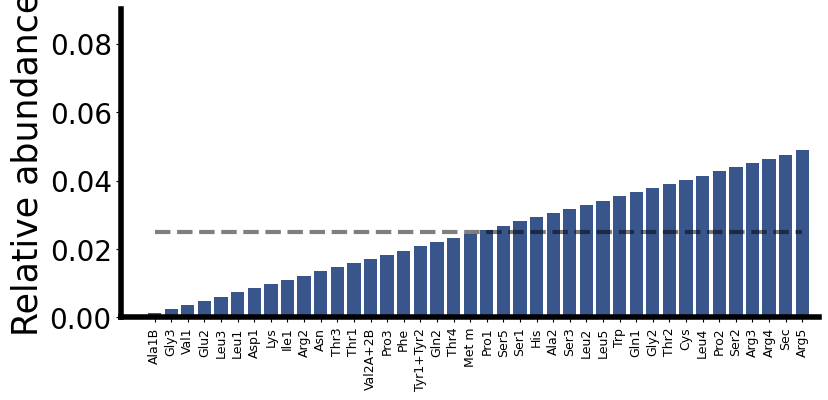

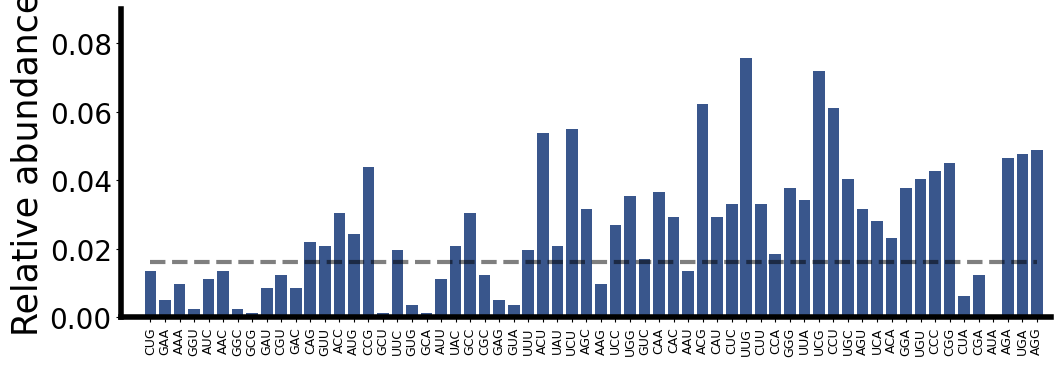

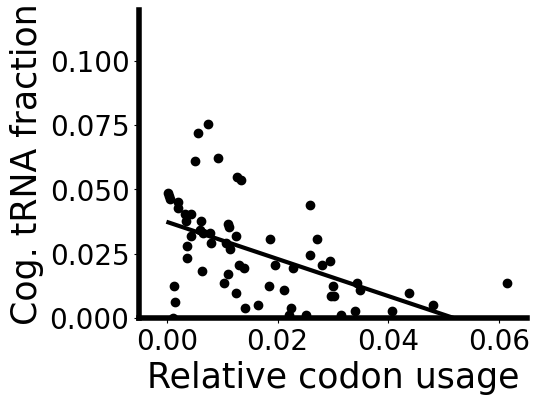

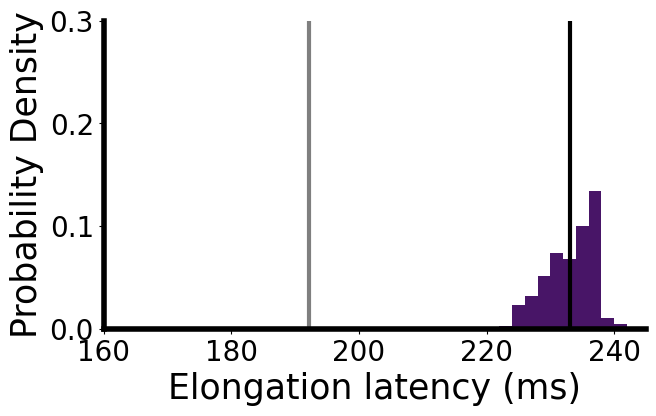

In [4]:
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


###Compute sorting for monotonic increase
##Compute WT transcriptome-ordered tRNA 
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]

##Assign monotonic increase to transcriptome-sorted tRNA
ptRNA_sorted = (0.12195+np.arange(0,40)*0.12195)/sum(0.12195+np.arange(0,40)*0.12195)
sortedtRNAdict = dict(zip(tRNA_sorted, ptRNA_sorted))
resortedtRNA = [sortedtRNAdict[tRNA] for tRNA in tRNA_tags]

##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(resortedtRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(resortedtRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
ax2.set_xlim(-2,40)
ax2.set_ylabel('Relative abundance',fontsize=25)
ptRNA_sorted_anticorrelated = ptRNA_sorted
print("ptRNA, ", ptRNA_sorted)

## Sort and plot cognate tRNA distribution per codon 
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('Relative abundance',fontsize=25)

for ax in [ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)


####Plot tRNA frequency vs. codon frequency######
fig,ax3 = plt.subplots(figsize=(5,4))
ax3.scatter(pCodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

y_model,SS_err,_,_,_ = np.polyfit(pCodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pCodon_sorted)
x_sweep_i = np.linspace(min(pCodon_sorted),max(pCodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax3.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pCodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pCodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)
ax3.set_xlim(-0.005,0.065)
ax3.set_ylim(0,0.12)
ax3.set_xlabel('Relative codon usage',fontsize=25)
ax3.set_ylabel('Cog. tRNA fraction',fontsize=25)


#Plot the elongation latency of each gene
fig1,ax4 = plt.subplots(figsize=(7,4))

hist=ax4.hist(transcriptome_elongt,color='#481567FF',bins=30,range=(210,270),density=True)

ax4.plot([np.average(transcriptome_elongt)]*100,np.linspace(0,0.4,100),linewidth=3,color='black')
ax4.plot([np.average(transcriptome_elongt_WT)]*100,np.linspace(0,0.4,100),linewidth=3,color='black',alpha=0.5)

print(np.average(transcriptome_elongt))
ax4.set_ylim(0,0.3)
ax4.set_xlim(160,245)
ax4.set_xlabel('Elongation latency (ms)',size=25)
ax4.set_ylabel('Probability Density',size=25)

for ax in [ax3,ax4]:
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)

fig.savefig('./Figures/2b-middle.svg', dpi=300,bbox_inches='tight')
fig1.savefig('./Figures/2b-right.svg', dpi=300,bbox_inches='tight')
    
print(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT))
print(computeEffectiveGrowthRateShift(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT)))

print("Min. transcript elongation latency: ", min(transcriptome_elongt))
print("Max. transcript elongation latency: ", max(transcriptome_elongt))
print("Standard deviation of elongation latency distrib:  ", np.std(transcriptome_elongt))

## Monotonic decrease (stepwise anticorrelated)

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in

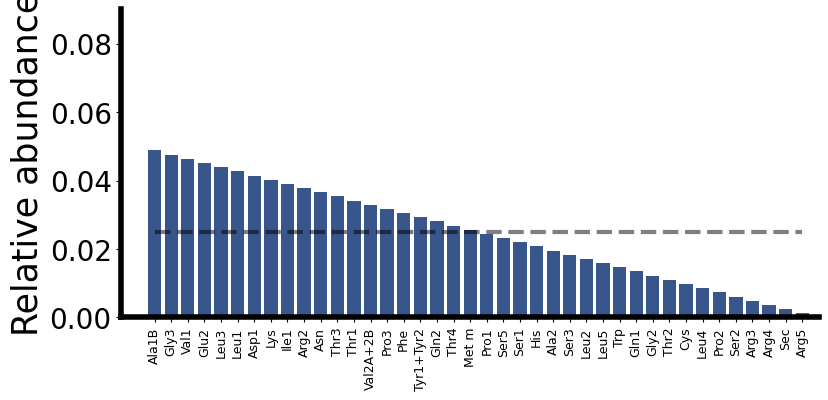

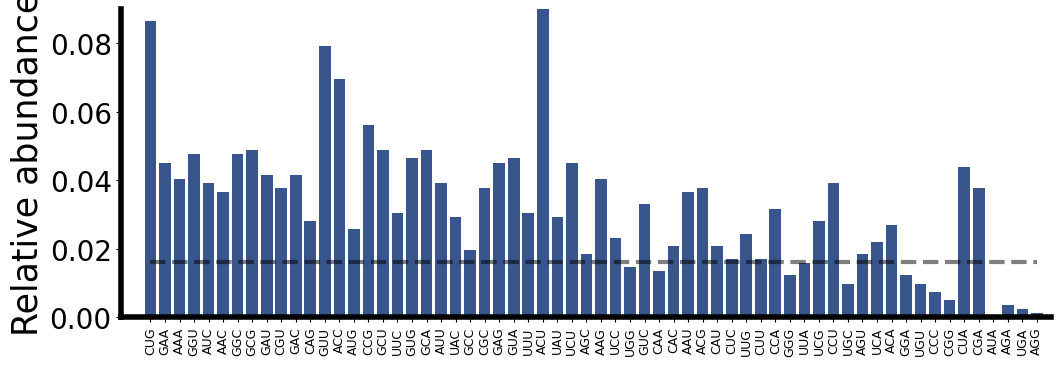

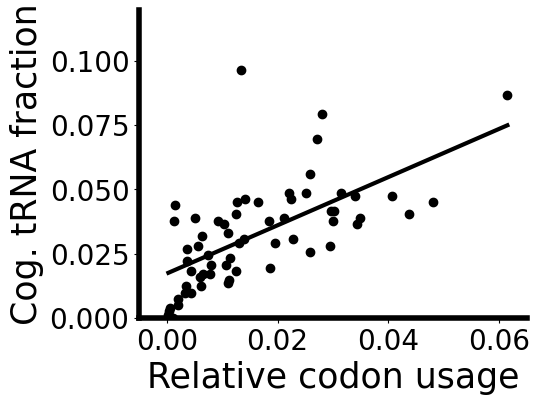

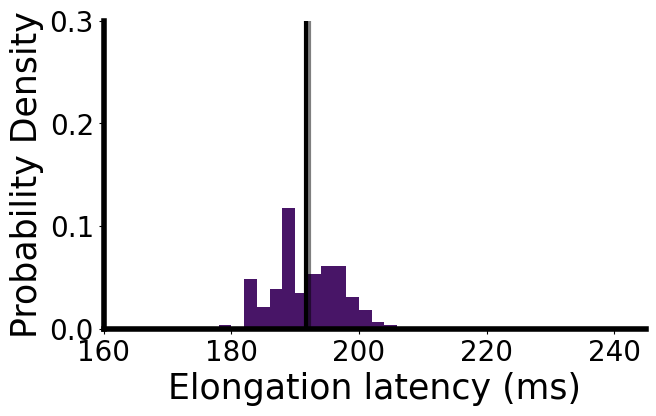

In [5]:
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


###Compute sorting for monotonic increase
##Compute WT transcriptome-ordered tRNA 
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]

##Assign monotonic increase to transcriptome-sorted tRNA
ptRNA_sorted = np.flip(0.12195+np.arange(0,40)*0.12195)/sum(0.12195+np.arange(0,40)*0.12195)
sortedtRNAdict = dict(zip(tRNA_sorted, ptRNA_sorted))
resortedtRNA = [sortedtRNAdict[tRNA] for tRNA in tRNA_tags]

##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(resortedtRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(resortedtRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
ax2.set_xlim(-2,40)
ax2.set_ylabel('Relative abundance',fontsize=25)
ptRNA_sorted_correlated = ptRNA_sorted
print("ptRNA ", ptRNA_sorted)


## Sort and plot cognate tRNA distribution per codon 
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('Relative abundance',fontsize=25)

for ax in [ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)


####Plot tRNA frequency vs. codon frequency######
fig,ax3 = plt.subplots(figsize=(5,4))
ax3.scatter(pCodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

y_model,SS_err,_,_,_ = np.polyfit(pCodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pCodon_sorted)
x_sweep_i = np.linspace(min(pCodon_sorted),max(pCodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax3.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pCodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pCodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)
ax3.set_xlim(-0.005,0.065)
ax3.set_ylim(0,0.12)
ax3.set_xlabel('Relative codon usage',fontsize=25)
ax3.set_ylabel('Cog. tRNA fraction',fontsize=25)


#Plot the elongation latency of each gene
fig1,ax4 = plt.subplots(figsize=(7,4))

hist=ax4.hist(transcriptome_elongt,color='#481567FF',bins=30,range=(160,220),density=True)
ax4.plot([np.average(transcriptome_elongt)]*100,np.linspace(0,0.4,100),linewidth=3,color='black')
ax4.plot([np.average(transcriptome_elongt_WT)]*100,np.linspace(0,0.4,100),linewidth=3,color='black',alpha=0.5)


print(np.average(transcriptome_elongt))
ax4.set_ylim(0,0.3)
ax4.set_xlim(160,245)
ax4.set_xlabel('Elongation latency (ms)',size=25)
ax4.set_ylabel('Probability Density',size=25)

for ax in [ax3,ax4]:
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
fig.savefig('./Figures/2c-middle.svg', dpi=300,bbox_inches='tight')
fig1.savefig('./Figures/2c-right.svg', dpi=300,bbox_inches='tight')

print(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT))
print(computeEffectiveGrowthRateShift(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT)))

print("Min. transcript elongation latency: ", min(transcriptome_elongt))
print("Max. transcript elongation latency: ", max(transcriptome_elongt))
print("Standard deviation of elongation latency distrib:  ", np.std(transcriptome_elongt))

## Codon weighted correlated

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in

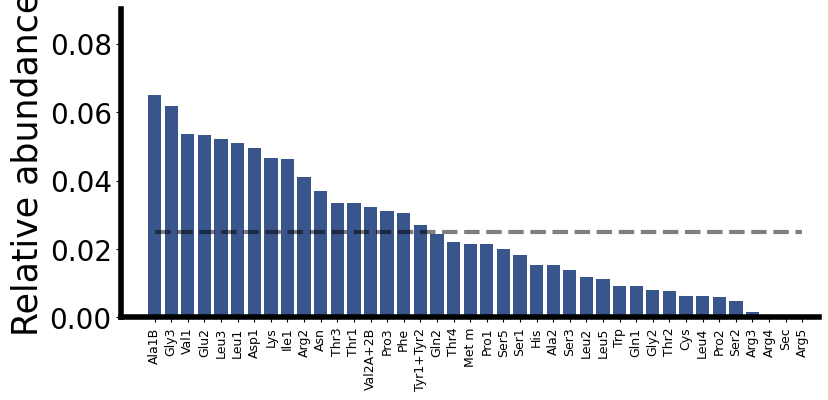

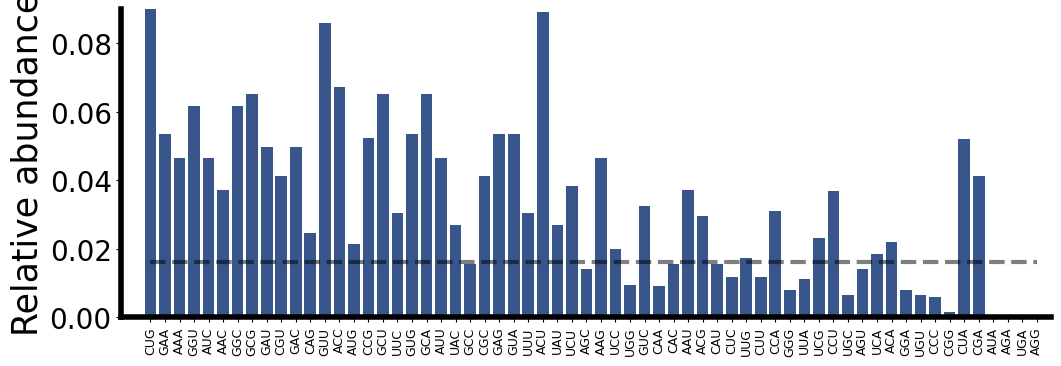

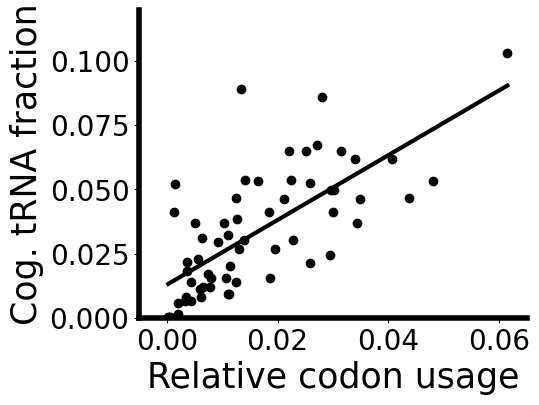

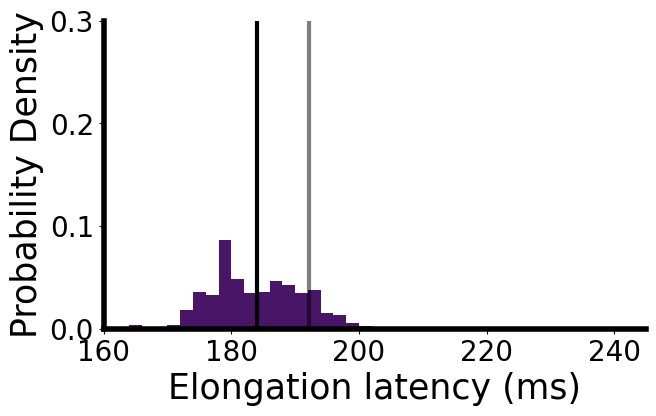

In [6]:
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


###Compute sorting for monotonic increase
##Compute WT transcriptome-ordered tRNA 
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]

##Assign monotonic increase to transcriptome-sorted tRNA
ptRNA_sorted = tRNA_weightedbycodon[tRNA_sorted_indices]
sortedtRNAdict = dict(zip(tRNA_sorted, ptRNA_sorted))
resortedtRNA = [sortedtRNAdict[tRNA] for tRNA in tRNA_tags]

##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(resortedtRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(resortedtRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),ptRNA_sorted,color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
ax2.set_xlim(-2,40)
ax2.set_ylabel('Relative abundance',fontsize=25)
ptRNA_sorted_correlatedCodon = ptRNA_sorted
print("ptRNA ", ptRNA_sorted)

## Sort and plot cognate tRNA distribution per codon 
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),ptRNA_sorted,color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('Relative abundance',fontsize=25)

for ax in [ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)


####Plot tRNA frequency vs. codon frequency######
fig,ax3 = plt.subplots(figsize=(5,4))
ax3.scatter(pCodon_sorted,ptRNA_sorted,color='black',label = 'Protein-coding codon')

y_model,SS_err,_,_,_ = np.polyfit(pCodon_sorted,ptRNA_sorted,1,full=True)
y_hat = np.polyval(y_model,pCodon_sorted)
x_sweep_i = np.linspace(min(pCodon_sorted),max(pCodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax3.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pCodon_sorted,ptRNA_sorted,y_hat))

slope, intercept = np.polyfit(pCodon_sorted,ptRNA_sorted,1)
print("slope: ", slope)
ax3.set_xlim(-0.005,0.065)
ax3.set_ylim(0,0.12)
ax3.set_xlabel('Relative codon usage',fontsize=25)
ax3.set_ylabel('Cog. tRNA fraction',fontsize=25)


#Plot the elongation latency of each gene
fig1,ax4 = plt.subplots(figsize=(7,4))

hist=ax4.hist(transcriptome_elongt,color='#481567FF',bins=30,range=(160,220),density=True)
ax4.plot([np.average(transcriptome_elongt)]*100,np.linspace(0,0.4,100),linewidth=3,color='black')
ax4.plot([np.average(transcriptome_elongt_WT)]*100,np.linspace(0,0.4,100),linewidth=3,color='black',alpha=0.5)


print(np.average(transcriptome_elongt))
ax4.set_ylim(0,0.3)
ax4.set_xlim(160,245)
ax4.set_xlabel('Elongation latency (ms)',size=25)
ax4.set_ylabel('Probability Density',size=25)

for ax in [ax3,ax4]:
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)

fig.savefig('./Figures/2d-middle.svg', dpi=300,bbox_inches='tight')
fig1.savefig('./Figures/2d-right.svg', dpi=300,bbox_inches='tight')

print(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT))
print(computeEffectiveGrowthRateShift(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT)))

print("Min. transcript elongation latency: ", min(transcriptome_elongt))
print("Max. transcript elongation latency: ", max(transcriptome_elongt))
print("Standard deviation of elongation latency distrib:  ", np.std(transcriptome_elongt))

In [7]:
## Codon-weighted anticorrelated

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
ptRNA  [0.10304984112196967, 0.053414946126424855, 0.04651254441450301, 0.06176656977268834, 0.046385791078539206, 0.036994975832781614, 0.06176656977268834, 0.06509161907426231, 0.049615852318250574, 0.04114369649351162, 0.049615852318250574, 0.024417026433126605, 0.08588355175861237, 0.06714837111081756, 0.021457277783716817, 0.052359102488777336, 0.06509161907426231, 0.03037229538750413, 0.05350537273889226, 0.06509161907426231, 

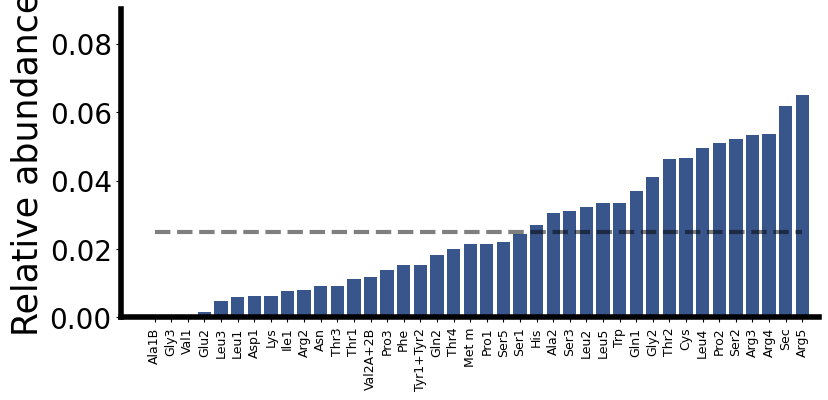

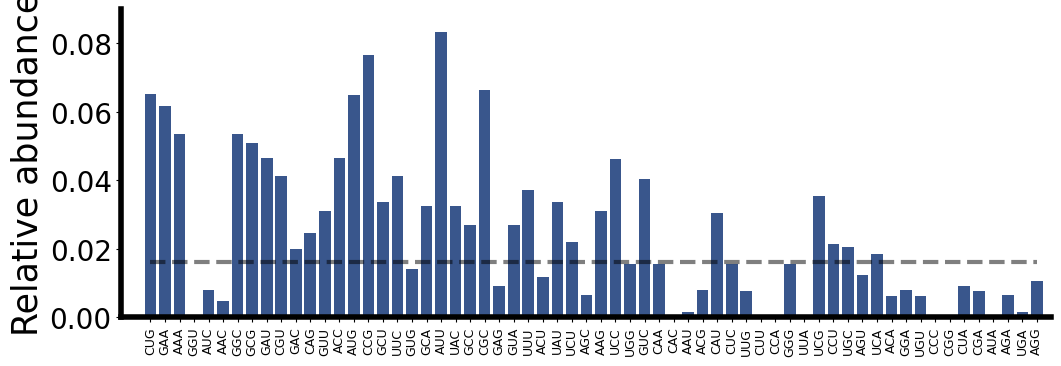

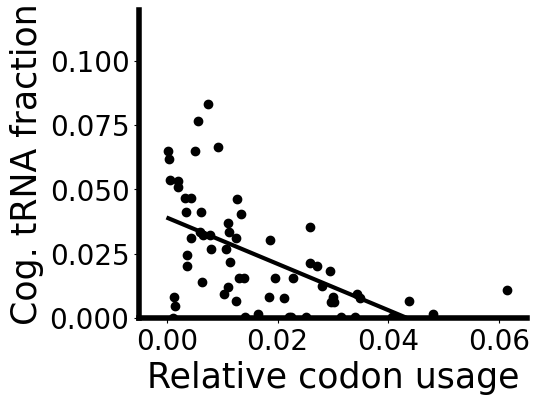

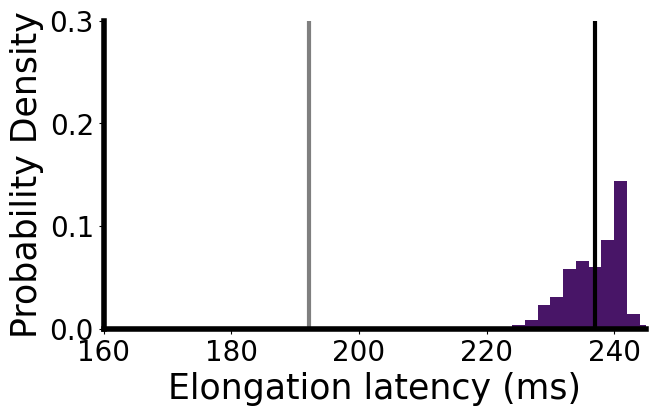

In [8]:
tRNA_tags = ['Ala1B', 'Ala2', 'Arg2', 'Arg3', 'Arg4', 'Arg5', 'Asn', 'Asp1', 'Cys', 'Gln1', 'Gln2', 'Glu2', 'Gly2', 'Gly3', 'His', 'Ile1', 'Leu1', 'Leu2', 'Leu3', 'Leu4', 'Leu5', 'Lys', 'Met m', 'Phe', 'Pro1', 'Pro2', 'Pro3', 'Sec', 'Ser1', 'Ser2', 'Ser3', 'Ser5', 'Thr1', 'Thr2', 'Thr3', 'Thr4', 'Trp', 'Tyr1+Tyr2', 'Val1', 'Val2A+2B']
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


###Compute sorting for monotonic increase
##Compute WT transcriptome-ordered tRNA 
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
print("ptRNA ", ptRNA_sorted)


##Assign monotonic increase to transcriptome-sorted tRNA
ptRNA_sorted = tRNA_weightedbycodon[tRNA_sorted_indices]
sortedtRNAdict = dict(zip(tRNA_sorted, np.flip(ptRNA_sorted)))
resortedtRNA = [sortedtRNAdict[tRNA] for tRNA in tRNA_tags]

##Compute the codon distribution and elongation latency of each gene weighted by transcript number
codon_elongt = compute_codon_elongt(resortedtRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map, gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map, gene_latency)

#Compute cognate distributions and sort codons by frequency
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(resortedtRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
fig,ax2 = plt.subplots(figsize=(9,4))
ax2.bar(np.arange(40),np.flip(ptRNA_sorted),color='#39568CFF',width=0.8)
ax2.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')
ax2.set_xlim(-2,40)
ax2.set_ylabel('Relative abundance',fontsize=25)
ptRNA_sorted_anticorrelatedCodon = np.flip(ptRNA_sorted)

## Sort and plot cognate tRNA distribution per codon 
tRNA_sorted = [codon_dict[codon] for codon in codon_sorted]
ptRNA_sorted = [sum([ptRNA_dict[key] for key in tRNAs]) for tRNAs in tRNA_sorted]
fig,ax1 = plt.subplots(figsize=(12,4))
ax1.bar(np.arange(62),np.flip(ptRNA_sorted),color='#39568CFF',width=0.8)
ax1.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax1.set_xlim(-2,62)
ax1.set_ylabel('Relative abundance',fontsize=25)

for ax in [ax1,ax2]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylim(0,0.09)


####Plot tRNA frequency vs. codon frequency######
fig,ax3 = plt.subplots(figsize=(5,4))
ax3.scatter(pCodon_sorted,(ptRNA_sorted),color='black',label = 'Protein-coding codon')

y_model,SS_err,_,_,_ = np.polyfit(pCodon_sorted,(ptRNA_sorted),1,full=True)
y_hat = np.polyval(y_model,pCodon_sorted)
x_sweep_i = np.linspace(min(pCodon_sorted),max(pCodon_sorted),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax3.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2: ",calc_R2(pCodon_sorted,(ptRNA_sorted),y_hat))

slope, intercept = np.polyfit(pCodon_sorted,(ptRNA_sorted),1)
print("slope: ", slope)
ax3.set_xlim(-0.005,0.065)
ax3.set_ylim(0,0.12)
ax3.set_xlabel('Relative codon usage',fontsize=25)
ax3.set_ylabel('Cog. tRNA fraction',fontsize=25)


#Plot the elongation latency of each gene
fig1,ax4 = plt.subplots(figsize=(7,4))

hist=ax4.hist(transcriptome_elongt,color='#481567FF',bins=30,range=(210,270),density=True)
ax4.plot([np.average(transcriptome_elongt)]*100,np.linspace(0,0.4,100),linewidth=3,color='black')
ax4.plot([np.average(transcriptome_elongt_WT)]*100,np.linspace(0,0.4,100),linewidth=3,color='black',alpha=0.5)

print(np.average(transcriptome_elongt))
ax4.set_ylim(0,0.3)
ax4.set_xlim(160,245)
ax4.set_xlabel('Elongation latency (ms)',size=25)
ax4.set_ylabel('Probability Density',size=25)

for ax in [ax3,ax4]:
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)

fig.savefig('./Figures/2e-middle.svg', dpi=300,bbox_inches='tight')
fig1.savefig('./Figures/2e-right.svg', dpi=300,bbox_inches='tight')

print(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT))
print(computeEffectiveGrowthRateShift(np.average(transcriptome_elongt)/np.average(transcriptome_elongt_WT)))

print("Min. transcript elongation latency: ", min(transcriptome_elongt))
print("Max. transcript elongation latency: ", max(transcriptome_elongt))
print("Standard deviation of elongation latency distrib:  ", np.std(transcriptome_elongt))

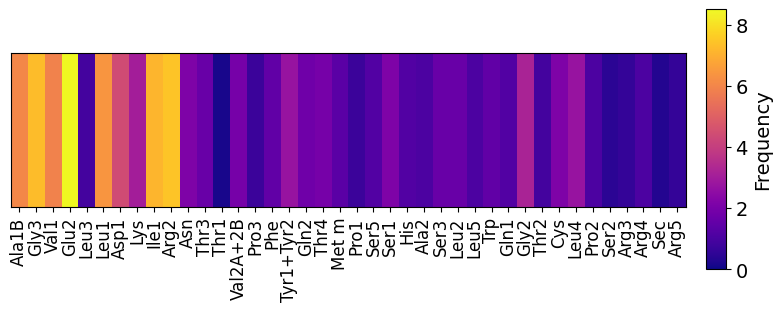

0.0015220700152021665


In [12]:
# Heatmap for wildtype
fig, ax = plt.subplots(figsize=(10,2))

x = np.arange(0,40)
y = np.array(ptRNA_sorted_WT)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:]*100, cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=8.52)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, -0.2, 0.02, 1.3])
cbar = fig.colorbar(heatmap, cax=cbar_ax,ticks=[0,2,4,6,8])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Frequency',size=14)

plt.show()
print(min(y))

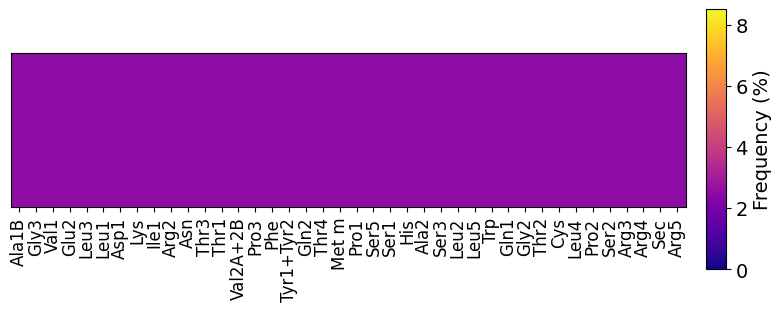

0.025


In [13]:
# Heatmap for uniform
fig, ax = plt.subplots(figsize=(10,2))


x = np.arange(0,40)
y = np.array(ptRNA_sorted_uniform)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:]*100, cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=8.52)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, -0.2, 0.02, 1.3])
cbar = fig.colorbar(heatmap, cax=cbar_ax,ticks=[0,2,4,6,8])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Frequency (%)',size=14)

plt.show()    
print(min(y))
fig.savefig('./Figures/2a-left.svg', dpi=300,bbox_inches='tight')

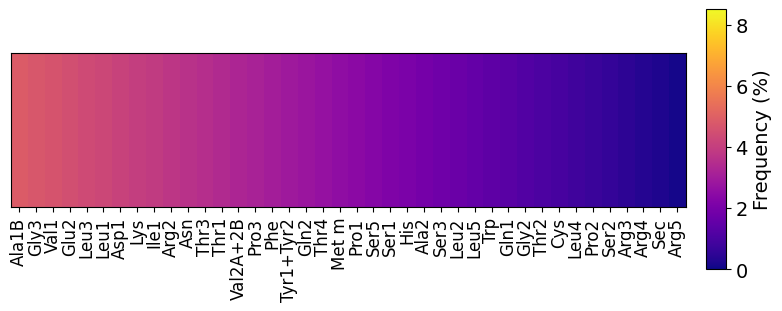

0.0012195121951219512


In [14]:
#Heatmap for tRNA stepwise correlated

fig, ax = plt.subplots(figsize=(10,2))

x = np.arange(0,40)
y = np.array(ptRNA_sorted_correlated)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:]*100, cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=8.52)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, -0.2, 0.02, 1.3])
cbar = fig.colorbar(heatmap, cax=cbar_ax,ticks=[0,2,4,6,8])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Frequency (%)',size=14)


plt.show()    
print(min(y))
fig.savefig('./Figures/2b-left.svg', dpi=300,bbox_inches='tight')

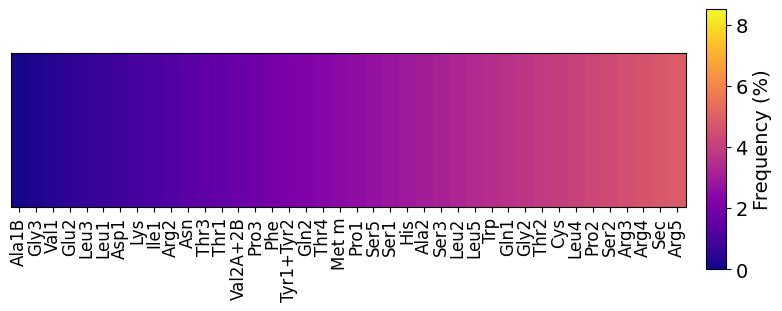

0.0012195121951219512


In [15]:
#Heatmap for tRNA stepwise anticorrelated

fig, ax = plt.subplots(figsize=(10,2))


x = np.arange(0,40)
y = np.array(ptRNA_sorted_anticorrelated)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:]*100, cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=8.52)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, -0.2, 0.02, 1.3])
cbar = fig.colorbar(heatmap, cax=cbar_ax,ticks=[0,2,4,6,8])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Frequency (%)',size=14)


plt.show()    
print(min(y))
fig.savefig('./Figures/2c-left.svg', dpi=300,bbox_inches='tight')

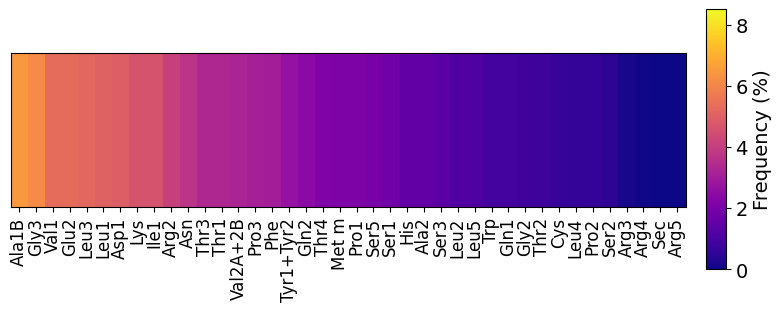

0.00023243607315527238


In [16]:
#Heatmap for tRNA codon-weighted correlated

fig, ax = plt.subplots(figsize=(10,2))

x = np.arange(0,40)
y = np.array(ptRNA_sorted_correlatedCodon)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:]*100, cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=8.52)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, -0.2, 0.02, 1.3])
cbar = fig.colorbar(heatmap, cax=cbar_ax,ticks=[0,2,4,6,8])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Frequency (%)',size=14)

plt.show()    
print(min(y))
fig.savefig('./Figures/2d-left.svg', dpi=300,bbox_inches='tight')

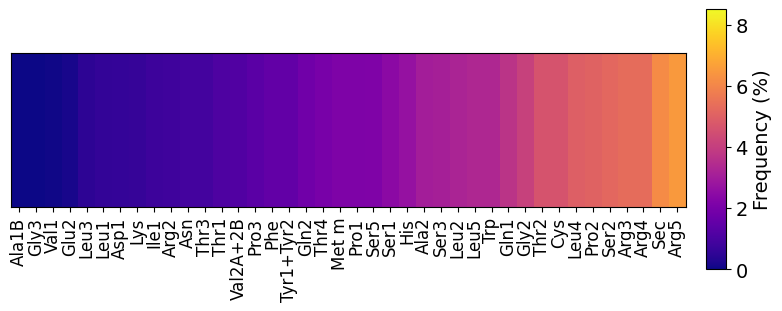

0.00023243607315527238


In [17]:
#Heatmap for tRNA codon-weighted anticorrelated

fig, ax = plt.subplots(figsize=(10,2))

x = np.arange(0,40)
y = np.array(ptRNA_sorted_anticorrelatedCodon)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:]*100, cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=8.52)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax.tick_params(axis='x', which='major', labelsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, -0.2, 0.02, 1.3])
cbar = fig.colorbar(heatmap, cax=cbar_ax,ticks=[0,2,4,6,8])
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Frequency (%)',size=14)

plt.show()    
print(min(y))
fig.savefig('./Figures/2e-left.svg', dpi=300,bbox_inches='tight')

# Extra plots

/var/folders/wr/cby0172x24d_6b7kwlbjy44r0000gn/T/ipykernel_11612/353011325.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


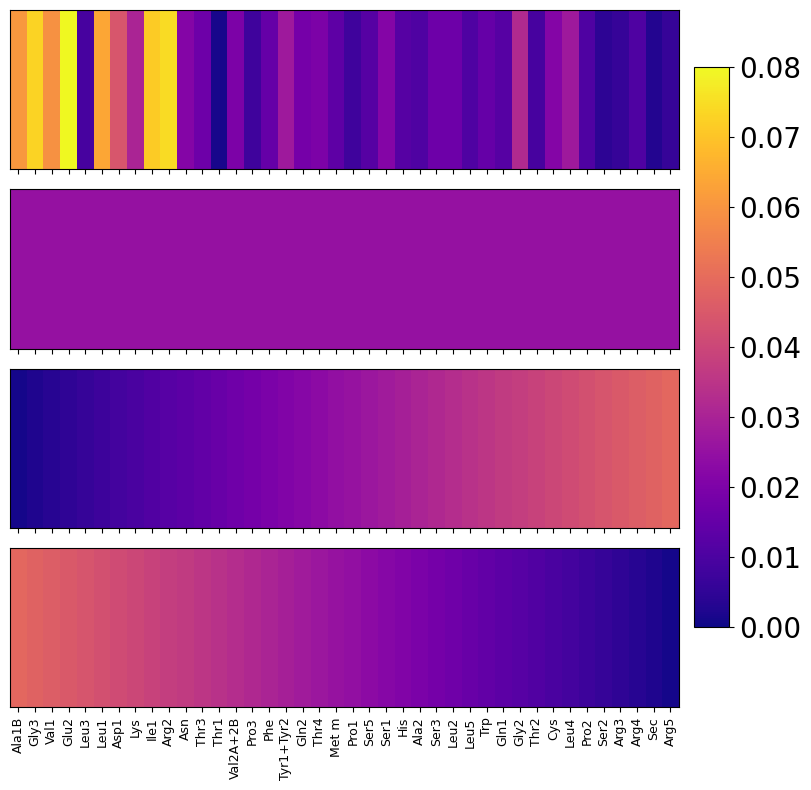

In [15]:
# Multiple together

fig, (ax,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True,figsize=(7,8))


x = np.arange(0,40)
y = np.array(ptRNA_sorted_WT)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.08)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

x = np.arange(0,40)
y = np.array(ptRNA_sorted_uniform)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax2.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.08)
ax2.set_yticks([])
ax2.set_xlim(extent[0], extent[1])

x = np.arange(0,40)
y = np.array(ptRNA_sorted_anticorrelated)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax3.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.08)
ax3.set_yticks([])
ax3.set_xlim(extent[0], extent[1])

x = np.arange(0,40)
y = np.array(ptRNA_sorted_correlated)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
heatmap = ax4.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent,vmin=0,vmax=0.08)
ax4.set_yticks([])
ax4.set_xlim(extent[0], extent[1])

plt.xticks(range(len(tRNA_tags)), tRNA_sorted_WT,rotation='vertical')
ax4.tick_params(axis='x', which='major', labelsize=9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.21, 0.05, 0.7])
cbar = fig.colorbar(heatmap, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()    

62